# Deep Learning with PyTorch : Build a Generative Adversarial Network 

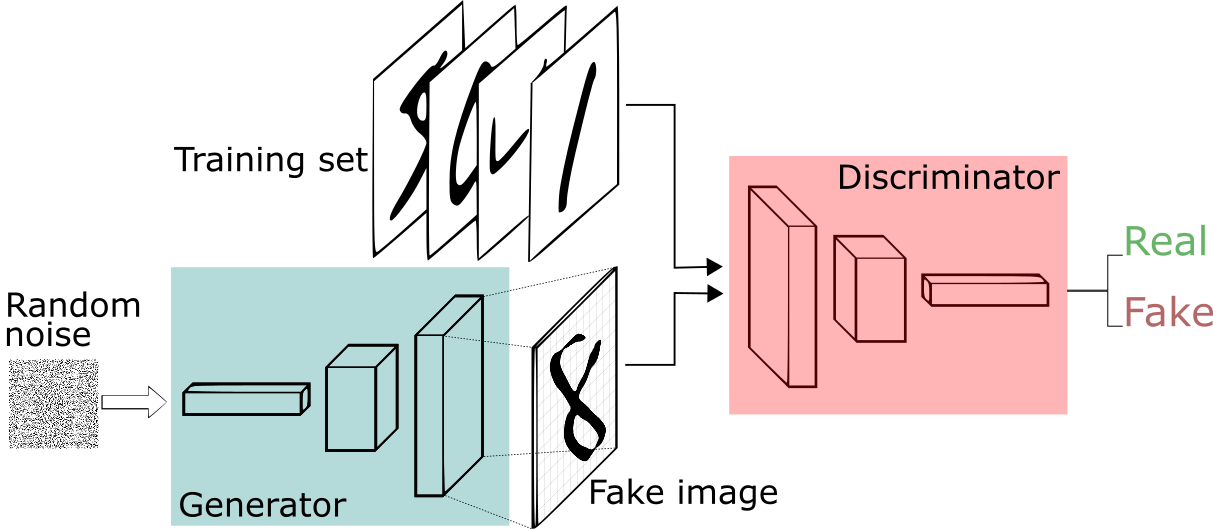

In [1]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [30]:
device = 'cuda' #image=image.to(device)

batch_size = 128

noise_dim = 64

#optimizers parameters

lr=0.0002
b1 = 0.5
b2 = .99

#Training variables
epochs=30

# Load MNIST Dataset 

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs  = T.Compose([
                          T.RandomRotation((-20,20)),
                         T.ToTensor() #convert numpy arrays or pil image to pytorch tensor which users (c,h,w) convention instead of (h,w,c)
                         
])

In [5]:
trainset= datasets.MNIST('MNIST/',download=True, train=True, transform=train_augs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



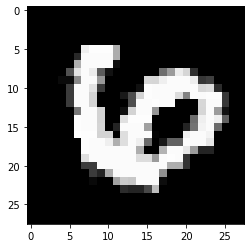

In [6]:
image, label = trainset[9000]

plt.imshow(image.squeeze(), cmap='gray')

# Load Dataset Into Batches 

In [7]:
print("total images present in trainset are :", len(trainset))

total images present in trainset are : 60000


In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)# datasets are loaded into batches through dataloader

In [10]:
print("Total no. of batches in trainloader: ", len(trainloader))

Total no. of batches in trainloader:  469


In [11]:
dataiter = iter(trainloader)

images, _ = dataiter.next()

print(images.shape)

torch.Size([128, 1, 28, 28])


In [12]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

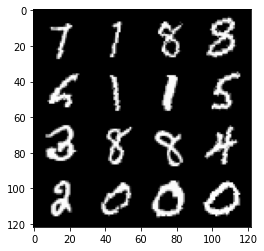

In [13]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network 

In [14]:
#In case if torch summary is not installed 

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [17]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [18]:
class Discriminator(nn.Module):
  def __init__(self):
     super(Discriminator, self).__init__()

     self.block_1 = get_disc_block(1, 16, (3,3), 2)
     self.block_2 = get_disc_block(16, 32, (5,5), 2)
     self.block_3 = get_disc_block(32, 64, (5,5), 2)

     self.flatten = nn.Flatten()
     self.linear = nn.Linear(in_features=64, out_features=1)

  def forward(self, images):

    x1= self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [19]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [21]:
def create_generator_block(in_channels, out_channels, kernel_size, stride, final_block =False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [22]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = create_generator_block(noise_dim, 256, (3,3), 2)
    self.block_2 = create_generator_block(256, 128, (4,4), 1)
    self.block_3 = create_generator_block(128, 64, (3,3), 2)

    self.block_4 = create_generator_block(64, 1, (4,4), 2, final_block=True)

  def forward(self, r_noise_vec):

    #(bs, noisedim) -> (bs, noise_dim, 1, 1)
    x = r_noise_vec.view(-1, self.noise_dim, 1,1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [23]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [24]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [25]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [26]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [27]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))

# Training Loop 

Epoch: 1 | D_loss: 0.6348075866699219 | G_loss: 0.8309399485588074 


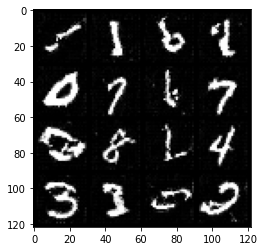

Epoch: 2 | D_loss: 0.6334938406944275 | G_loss: 0.8362314105033875 


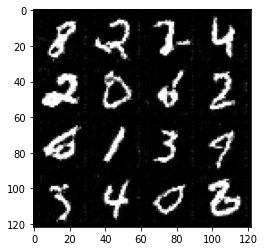

Epoch: 3 | D_loss: 0.6335263848304749 | G_loss: 0.8398573398590088 


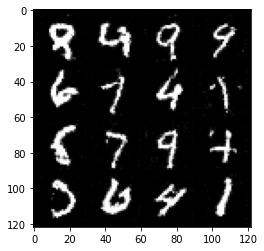

Epoch: 4 | D_loss: 0.6325865387916565 | G_loss: 0.8403216004371643 


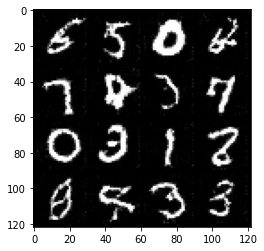

Epoch: 5 | D_loss: 0.6309067606925964 | G_loss: 0.8441107869148254 


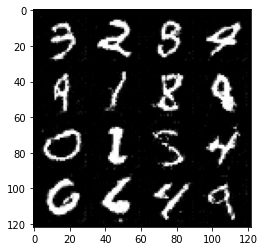

Epoch: 6 | D_loss: 0.6303224563598633 | G_loss: 0.8477445840835571 


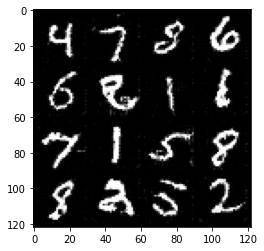

Epoch: 7 | D_loss: 0.6280943155288696 | G_loss: 0.8544479012489319 


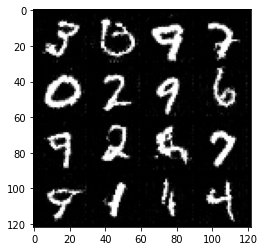

Epoch: 8 | D_loss: 0.6265334486961365 | G_loss: 0.8598425388336182 


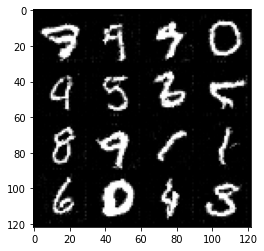

Epoch: 9 | D_loss: 0.6222974061965942 | G_loss: 0.8664085865020752 


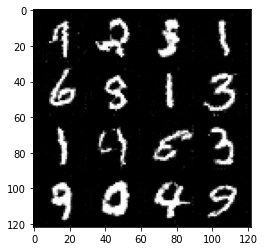

Epoch: 10 | D_loss: 0.6220006346702576 | G_loss: 0.8717822432518005 


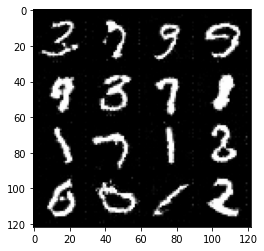

Epoch: 11 | D_loss: 0.6195922493934631 | G_loss: 0.876894474029541 


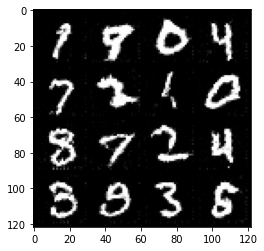

Epoch: 12 | D_loss: 0.620319128036499 | G_loss: 0.8769418001174927 


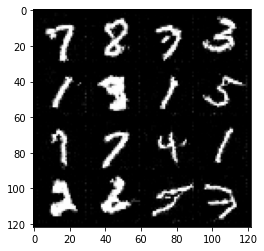

Epoch: 13 | D_loss: 0.6192415356636047 | G_loss: 0.8797095417976379 


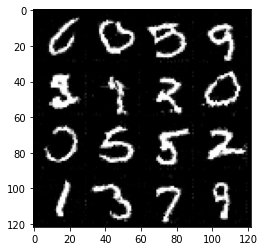

Epoch: 14 | D_loss: 0.6178309321403503 | G_loss: 0.8839946985244751 


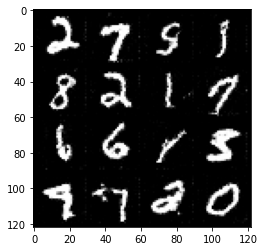

Epoch: 15 | D_loss: 0.6157287955284119 | G_loss: 0.8900091648101807 


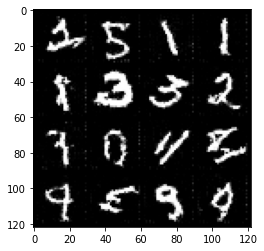

Epoch: 16 | D_loss: 0.6157616972923279 | G_loss: 0.8945393562316895 


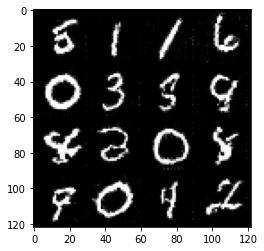

Epoch: 17 | D_loss: 0.6164973974227905 | G_loss: 0.8934662342071533 


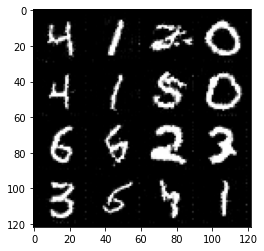

Epoch: 18 | D_loss: 0.6133831739425659 | G_loss: 0.9007620215415955 


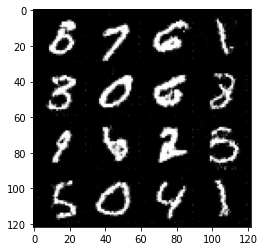

Epoch: 19 | D_loss: 0.6127548813819885 | G_loss: 0.9017883539199829 


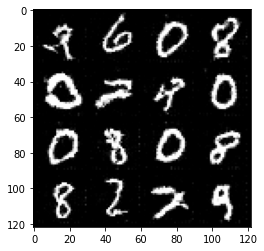

Epoch: 20 | D_loss: 0.6111372709274292 | G_loss: 0.9071917533874512 


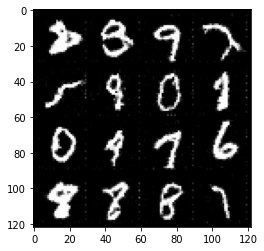

Epoch: 21 | D_loss: 0.6098504066467285 | G_loss: 0.9098042249679565 


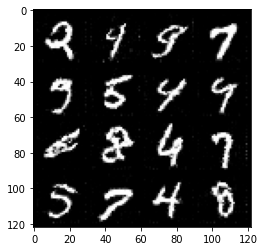

Epoch: 22 | D_loss: 0.6071150302886963 | G_loss: 0.915274441242218 


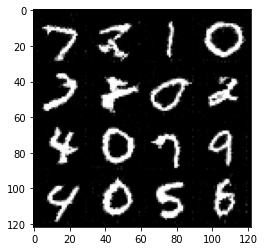

Epoch: 23 | D_loss: 0.6067960262298584 | G_loss: 0.9218844175338745 


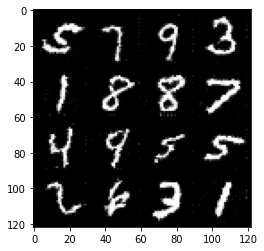

Epoch: 24 | D_loss: 0.6062960624694824 | G_loss: 0.9253717660903931 


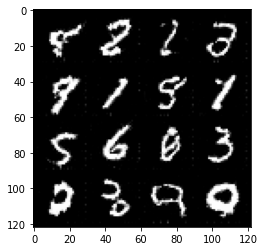

Epoch: 25 | D_loss: 0.6047771573066711 | G_loss: 0.9314262270927429 


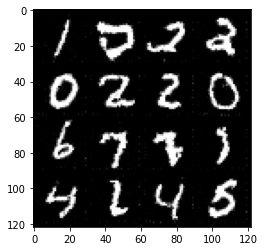

Epoch: 26 | D_loss: 0.601746141910553 | G_loss: 0.934695839881897 


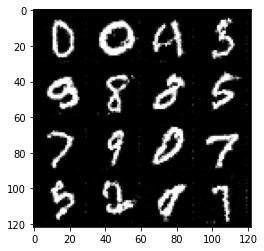

Epoch: 27 | D_loss: 0.599263608455658 | G_loss: 0.9440370202064514 


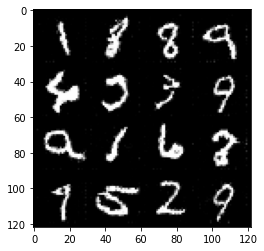

Epoch: 28 | D_loss: 0.5977227091789246 | G_loss: 0.948131799697876 


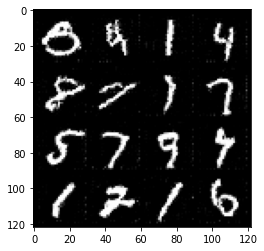

Epoch: 29 | D_loss: 0.59821617603302 | G_loss: 0.9472922682762146 


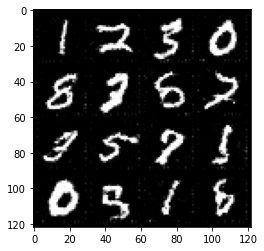

Epoch: 30 | D_loss: 0.5986654758453369 | G_loss: 0.9546661376953125 


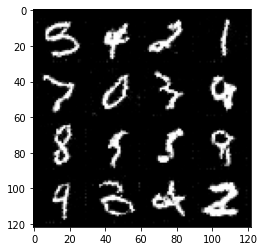

In [31]:
for i in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in trainloader:
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    #find loss and update weights for D

    D_opt.zero_grad() #make sure that gradients are zero

    fake_img = G(noise) #this is actually a r_noise_vec of shape (batch_size, noise_dim)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss

    D_loss.backward()#find the gradients
    D_opt.step() # update the parameters(weights and biases) of discriminator network


    #find loss and update weightd for G

    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device=device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)#we pass the D_pred to real_loss cause we want generator to produce realistic fake images i.e for predictions to be close to 1(which is what we have set in real_loss)

    total_g_loss += G_loss

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)
  print(f'Epoch: {i+1} | D_loss: {avg_d_loss} | G_loss: {avg_g_loss} ')

  show_tensor_images(fake_img)

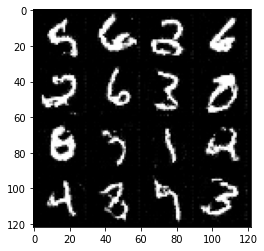

In [29]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)